In [1]:
import sys 

sys.path.insert(0, "/forecaster/src")
sys.path.insert(0, "/pyslds")
sys.path.insert(0, "/pybasicbayes")

In [26]:
import dataclasses
from pathlib import Path 
from typing import Optional

from matplotlib.cm import get_cmap 
from matplotlib.gridspec import GridSpec 
import matplotlib.pyplot as plt 
import numpy as np 
import numpy.random as npr 
import jax.numpy as jnp 
from jax import jit, grad, vmap
import jax.random as jnpr 
from statsmodels.tsa.stattools import acf 
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import Lasso, Ridge

from dataset import ForecastingConfig, ForecastingDataset, SegmentationConfig, SegmentationDataset
from metrics import rms, percentage_error
from models import last_value, RunningAverage

from pybasicbayes.distributions import DiagonalRegression, Gaussian, Regression
from pyslds.models import DefaultSLDS, WeakLimitHDPHMMSLDS
from pybasicbayes.util.text import progprint_xrange
from pylds.util import random_rotation

npr.seed(18)

In [14]:
K = 3 
D_latent = 3 
D_input = 0
D_obs = 1 

init_dynamics_distributions = [
    Gaussian(
        nu_0=D_latent+3,
        sigma_0=3.*np.eye(D_latent),
        mu_0=np.zeros(D_latent),
        kappa_0=0.01
        ) for _ in range(K)
        ]

dynamics_distributions = [
    Regression(
    nu_0=D_latent + 1,
    S_0=D_latent * np.eye(D_latent),
    M_0=np.hstack((.99 * np.eye(D_latent), np.zeros((D_latent, D_input)))),
    K_0=D_latent * np.eye(D_latent + D_input)) for _ in range(K)
    ]


    
As = [random_rotation(D_latent) for _ in range(K)]

for dd, A in zip(dynamics_distributions, As):
    dd.A = A


sigma_statess = [np.eye(D_latent) for _ in range(K)]


for dd, sigma in zip(dynamics_distributions, sigma_statess):
    dd.sigma = sigma

emission_distributions = [Regression(
    nu_0=D_obs + 1,
    S_0=D_obs * np.eye(D_obs),
    M_0=np.zeros((D_obs, D_latent + D_input)),
    K_0=D_obs * np.eye(D_latent + D_input))
    for _ in range(K)]


Cs = [np.zeros((D_obs, D_latent + D_input)) for _ in range(K)]
sigma_obss = [0.05 * np.eye(D_obs) for _ in range(K)]

for ed, C, sigma in zip(emission_distributions, Cs, sigma_obss):
    ed.A = C
    ed.sigma = sigma
        
model = WeakLimitHDPHMMSLDS(
    dynamics_distributions, 
    emission_distributions, 
    init_dynamics_distributions,
    alpha=1., 
    gamma=6., 
)

/pybasicbayes/pybasicbayes/distributions/regression.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([A,B,C,d])
/pybasicbayes/pybasicbayes/distributions/regression.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(


In [27]:
@dataclasses.dataclass 
class SLDSConfig: 
    num_states: Optional[int]=5
    observation_dimension: Optional[int]=1
    latent_dimension: Optional[int]=3
    input_dimension: Optional[int]=0

In [28]:
config = SLDSConfig(
    num_states=2
)

As = [random_rotation(config.latent_dimension) for _ in range(config.num_states)]

model = DefaultSLDS(
    config.num_states, 
    config.observation_dimension, 
    config.latent_dimension, 
    D_input=config.input_dimension, 
    As=As, 
    alpha=1., 
    )

/pybasicbayes/pybasicbayes/distributions/regression.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([A,B,C,d])
/pybasicbayes/pybasicbayes/distributions/regression.py:199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(


In [5]:
data_config = SegmentationConfig(
    data_source=Path("/forecaster/data/aggregated.pkl"), 
)
segmentation_dataset = SegmentationDataset(data_config) 

2023-08-16 16:07:00,501 INFO Deserialized source data from: /forecaster/data/aggregated.pkl


In [29]:
data_config = SegmentationConfig(
    data_source=Path("/forecaster/data/aggregated.pkl"), 
)
segmentation_dataset = SegmentationDataset(data_config) 

data = segmentation_dataset.data[0]
smooth: callable = lambda x, order=5: np.convolve(x, np.ones(order) / order, mode="same")[order:-order]

data = smooth(data[0, :], order=3)

num_timesteps: int = data.shape[-1]
fit_proportion: float = 0.75 
num_train: int = int(num_timesteps * fit_proportion)
x: np.ndarray = data[:num_train]
x_test: np.ndarray = data[num_train:]

2023-08-16 17:27:47,753 INFO Deserialized source data from: /forecaster/data/aggregated.pkl


2023-08-16 15:53:13,126 INFO Deserialized source data from: /forecaster/data/aggregated.pkl


seed: 0


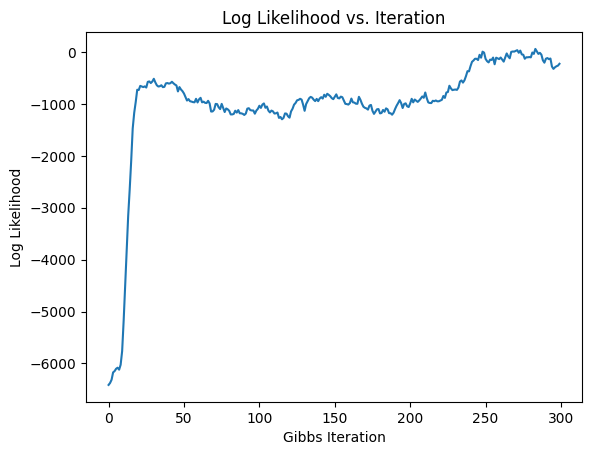

/tmp/ipykernel_149143/3645715995.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("jet")


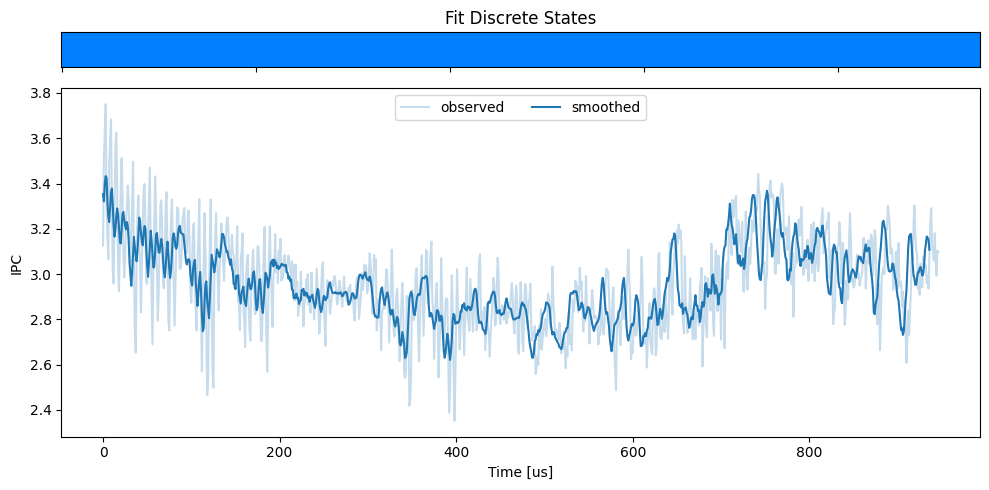

seed: 1


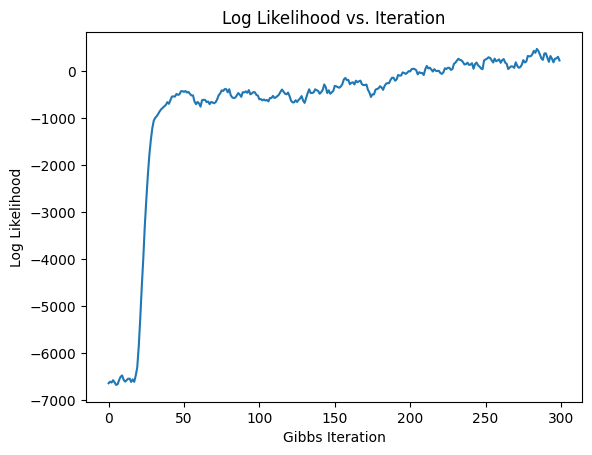

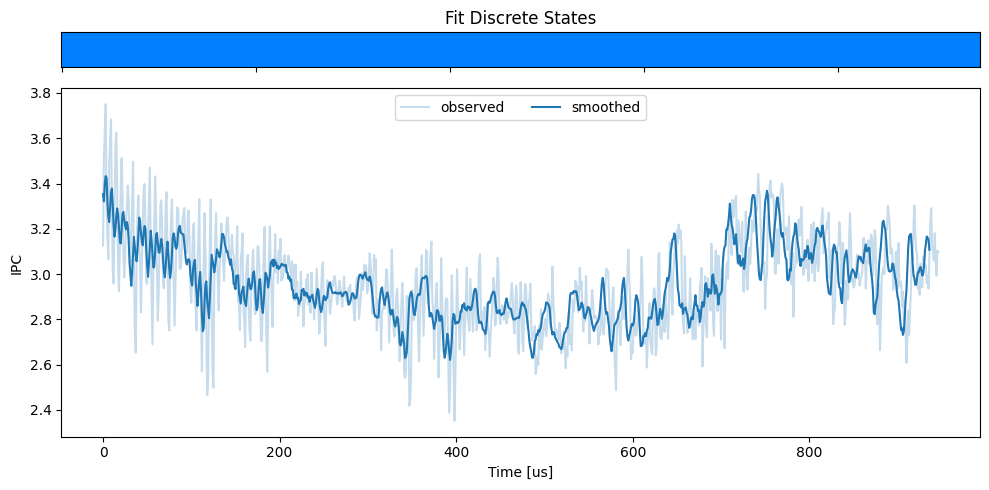

seed: 2


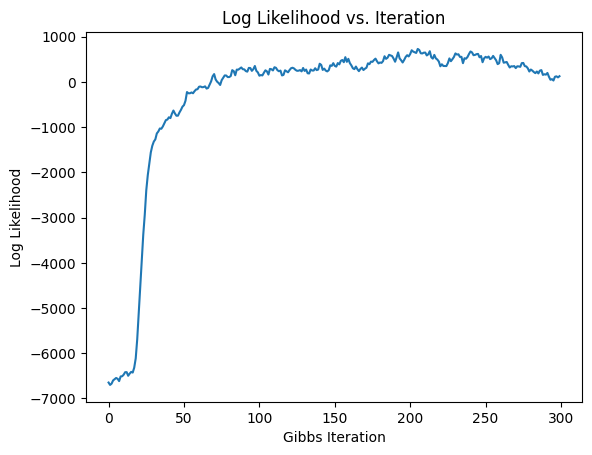

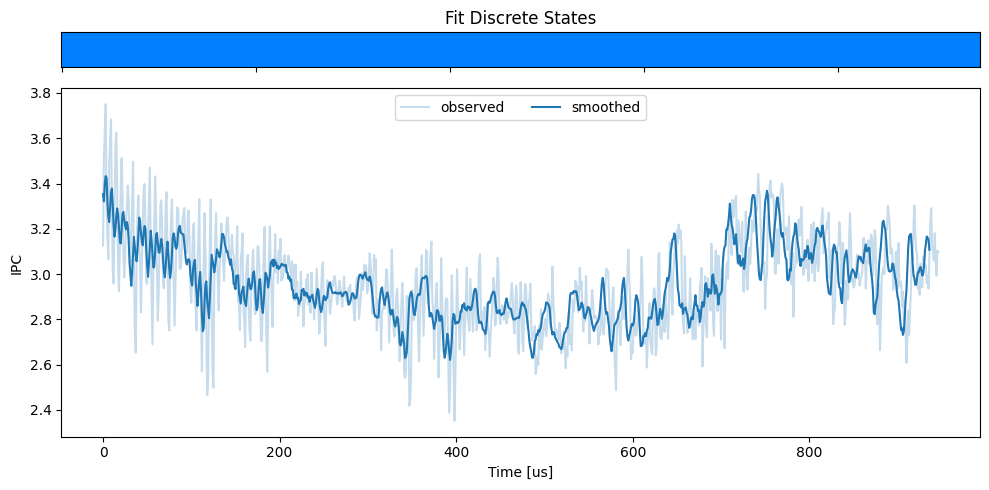

seed: 3


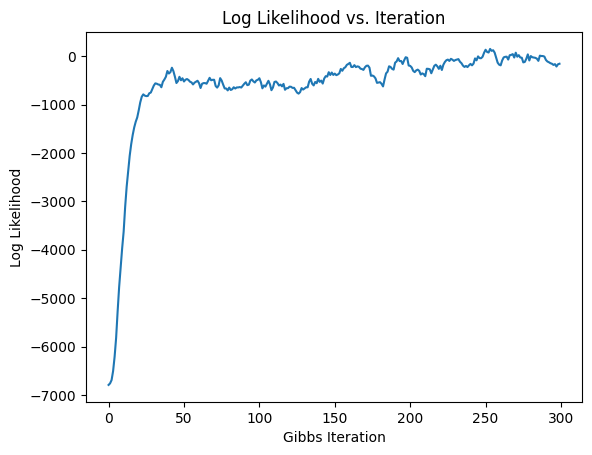

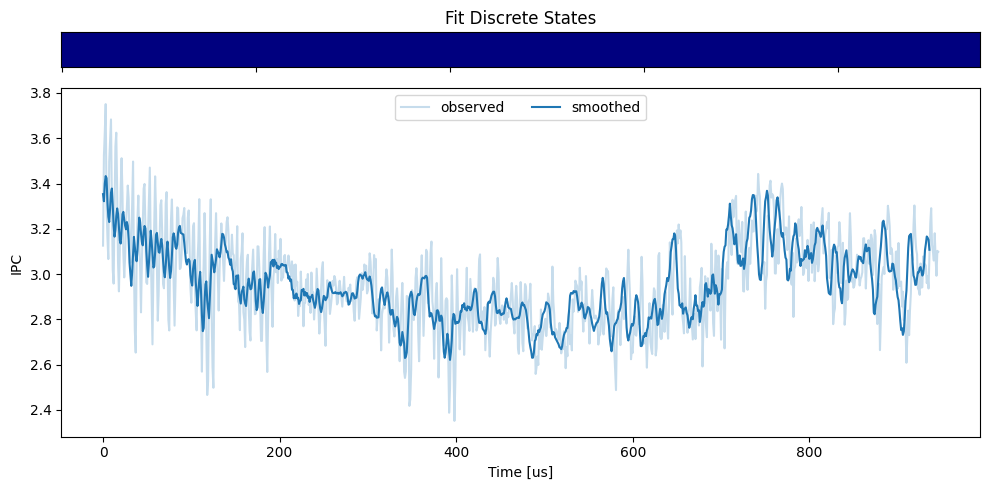

seed: 4


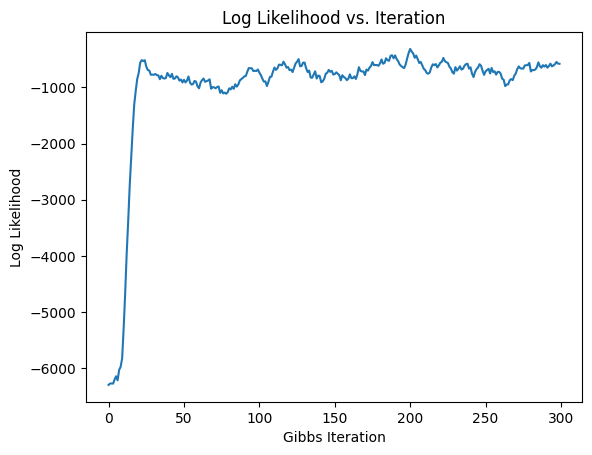

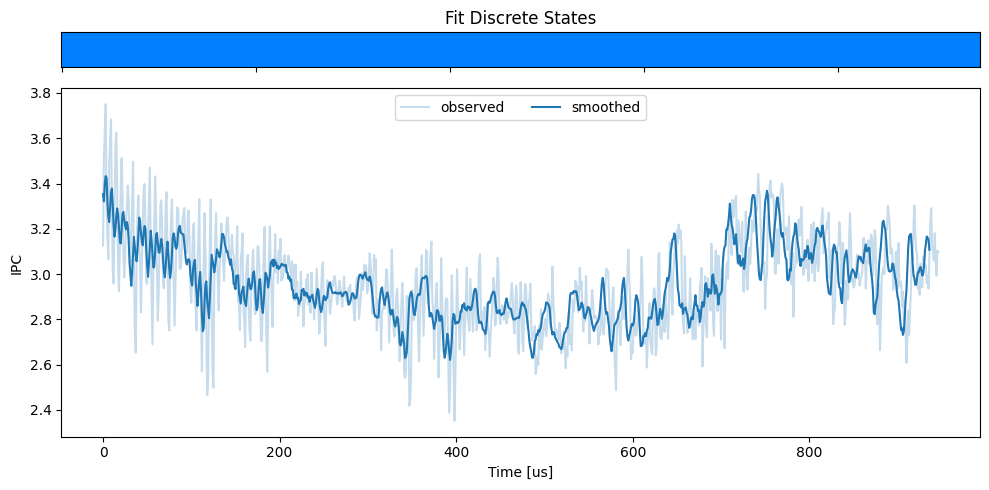

seed: 5


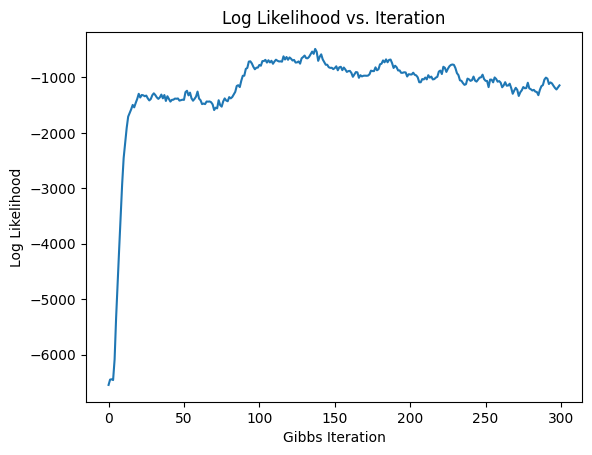

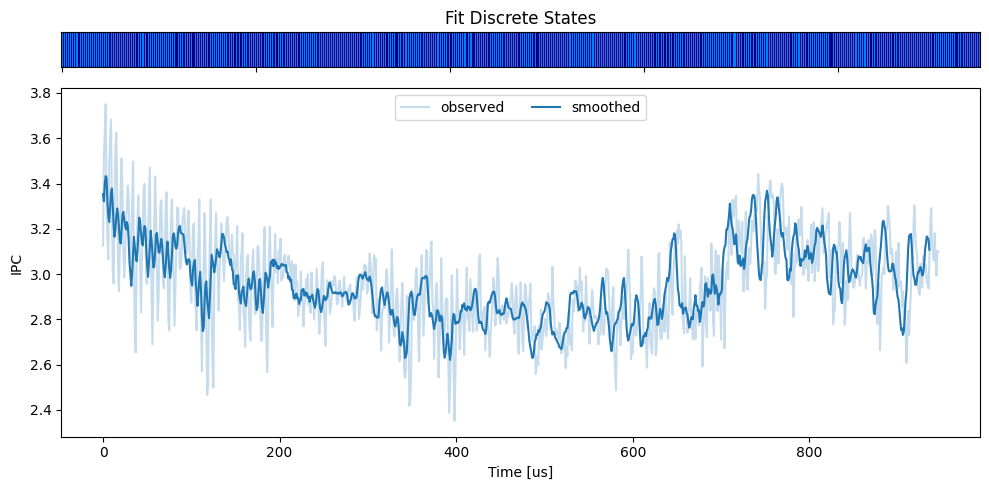

seed: 6


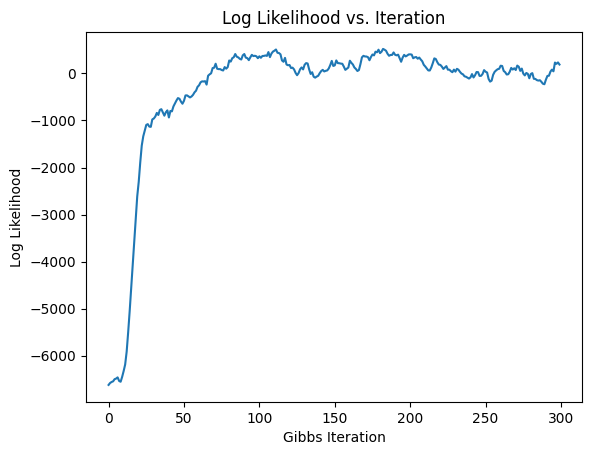

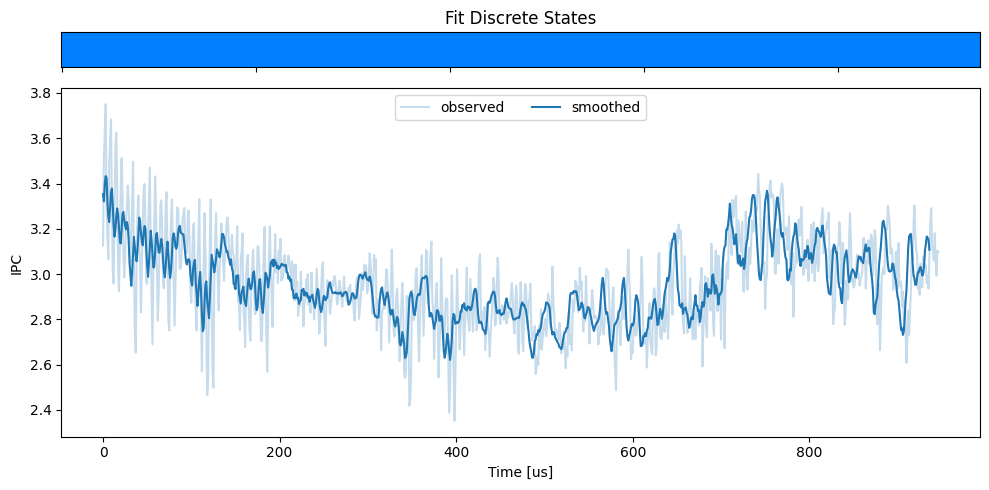

seed: 7


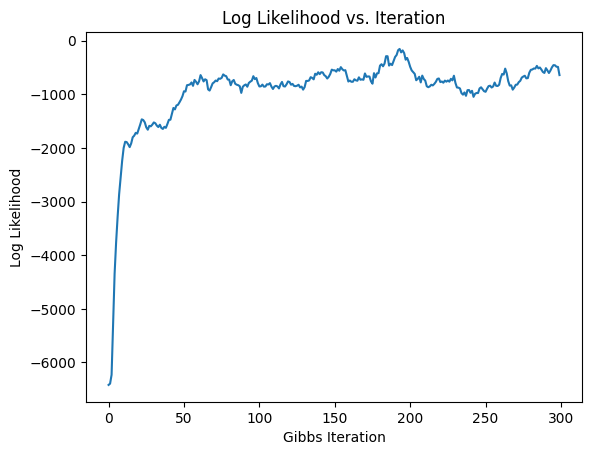

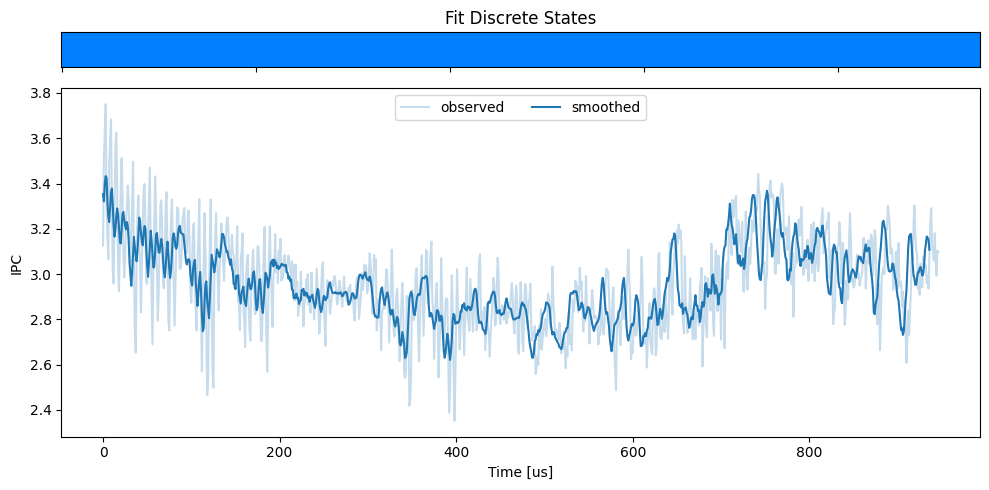

seed: 8


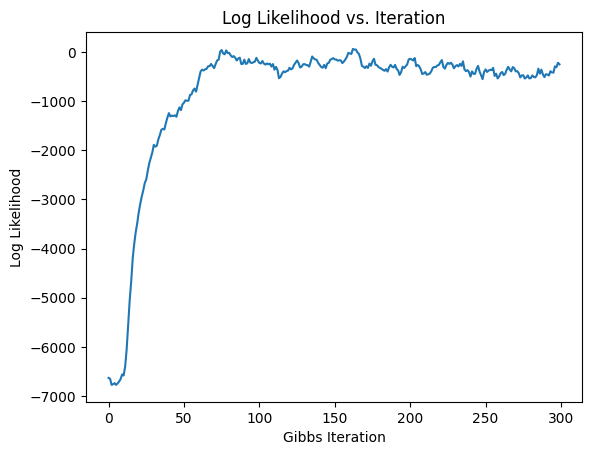

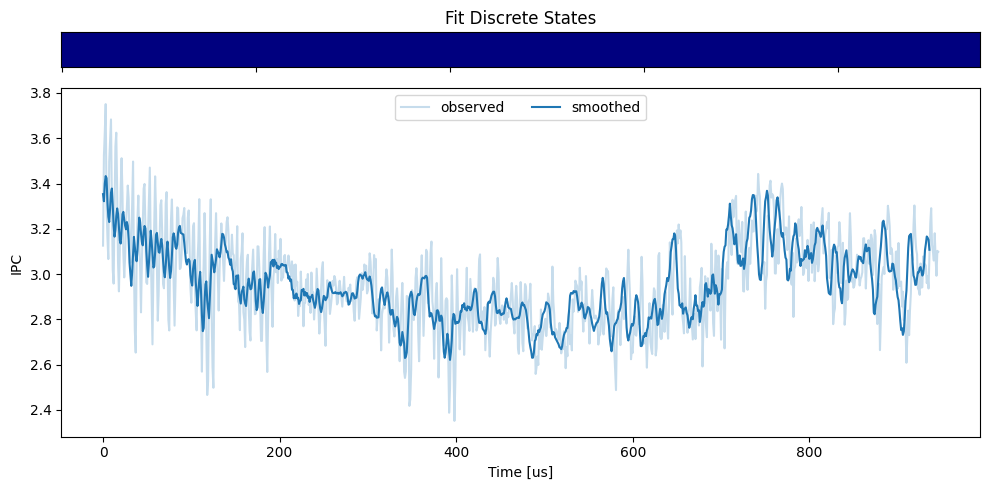

seed: 9


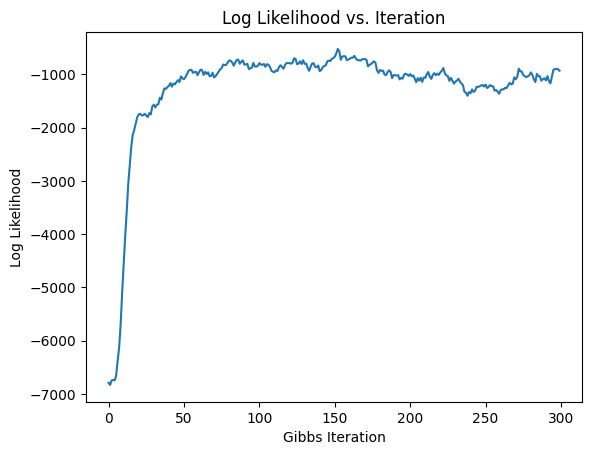

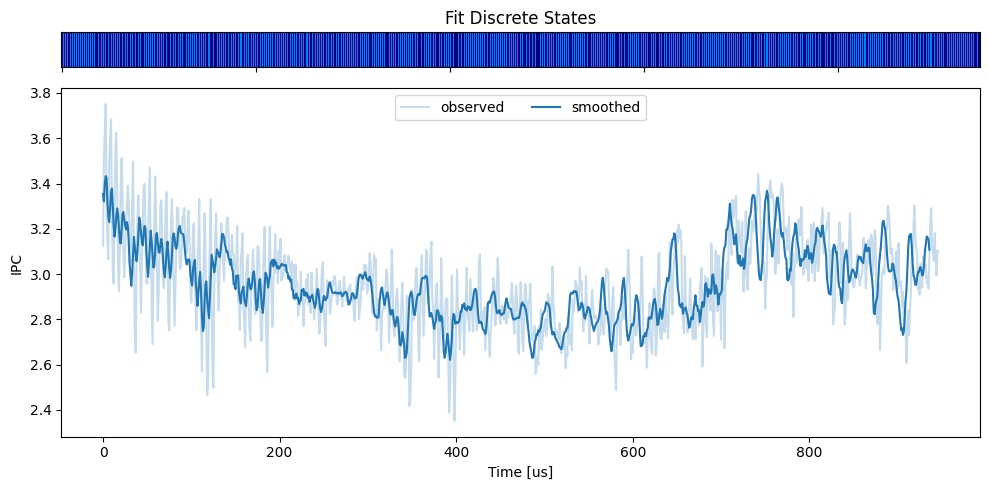

seed: 10


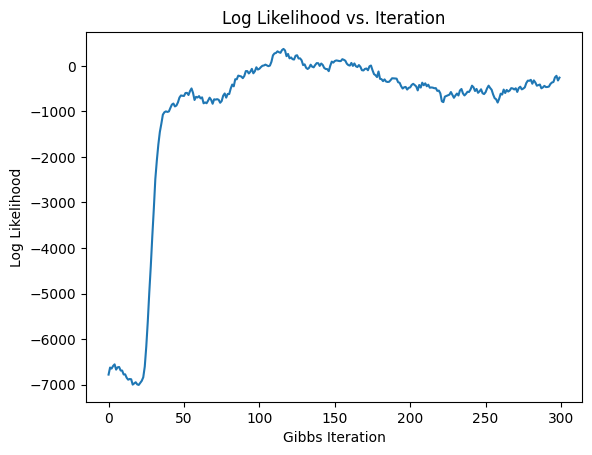

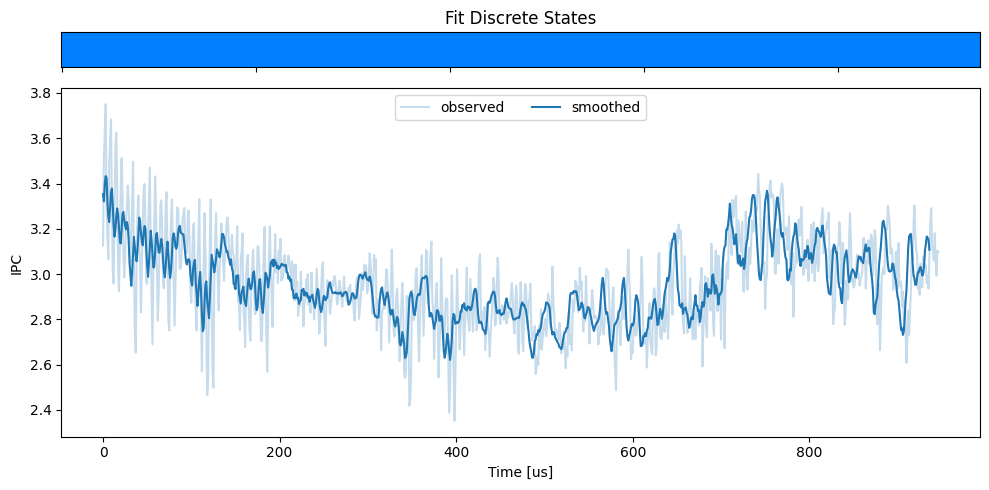

seed: 11


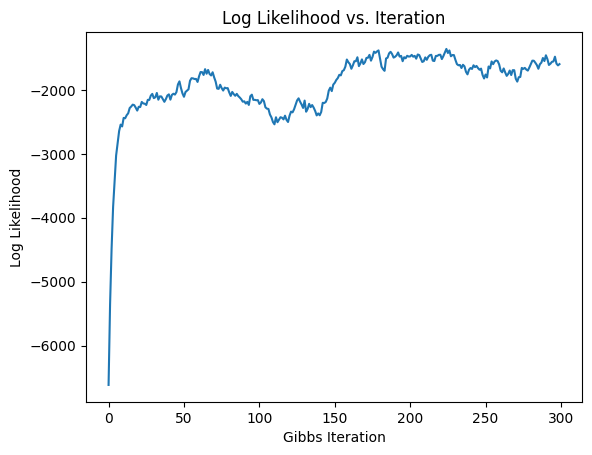

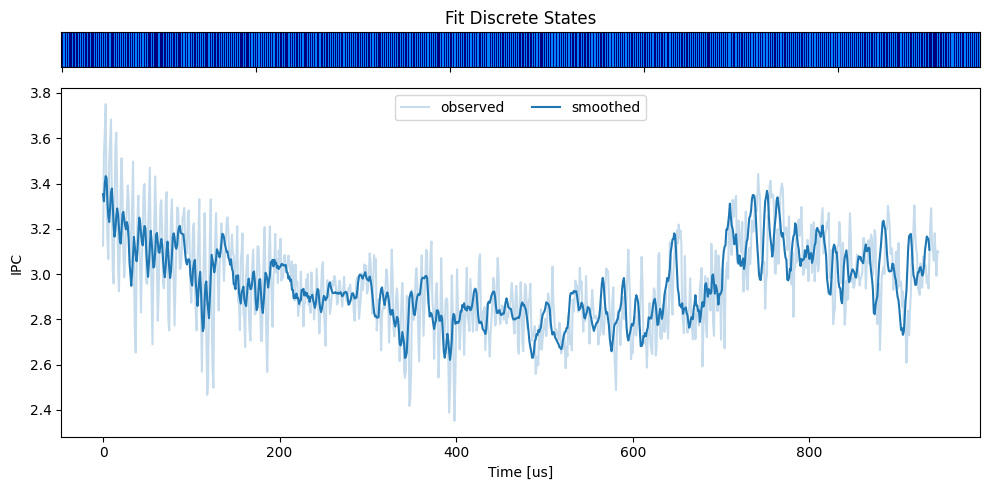

seed: 12


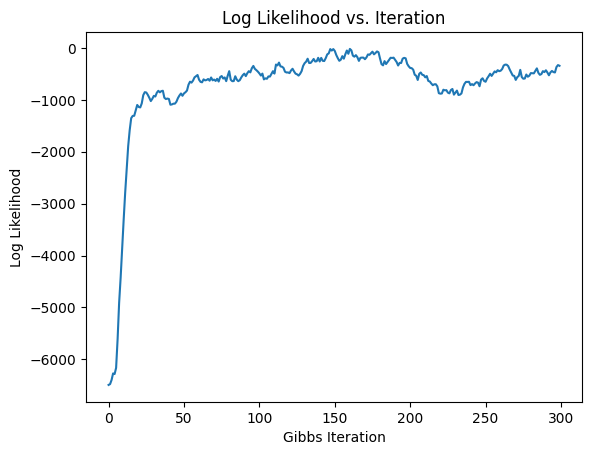

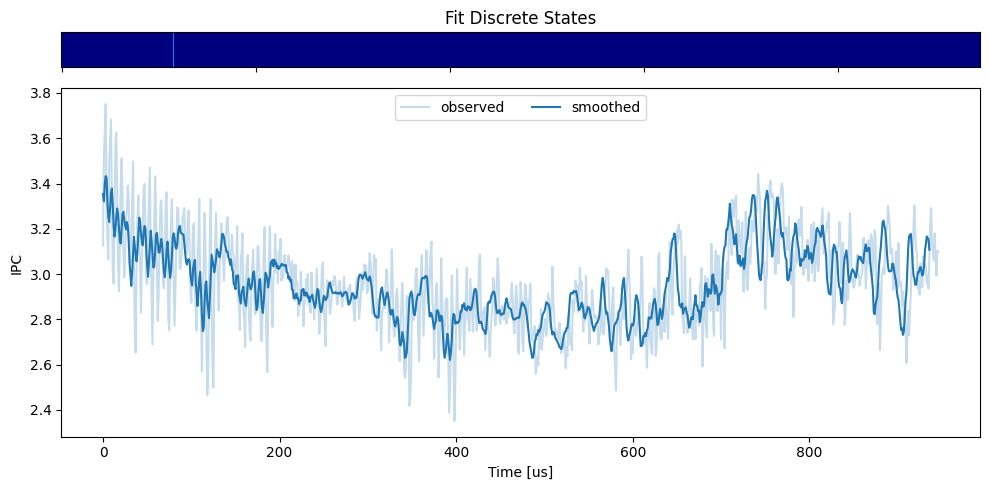

seed: 13


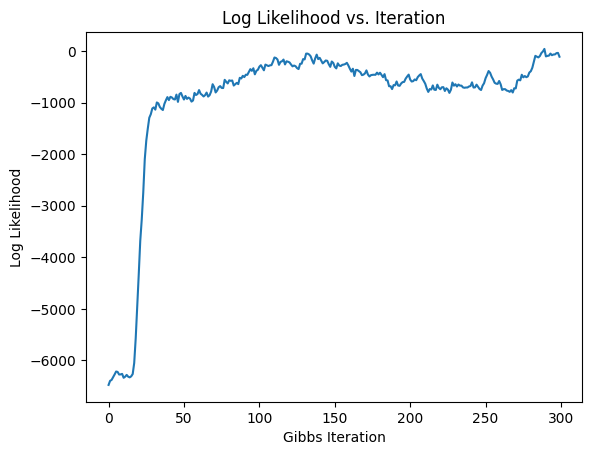

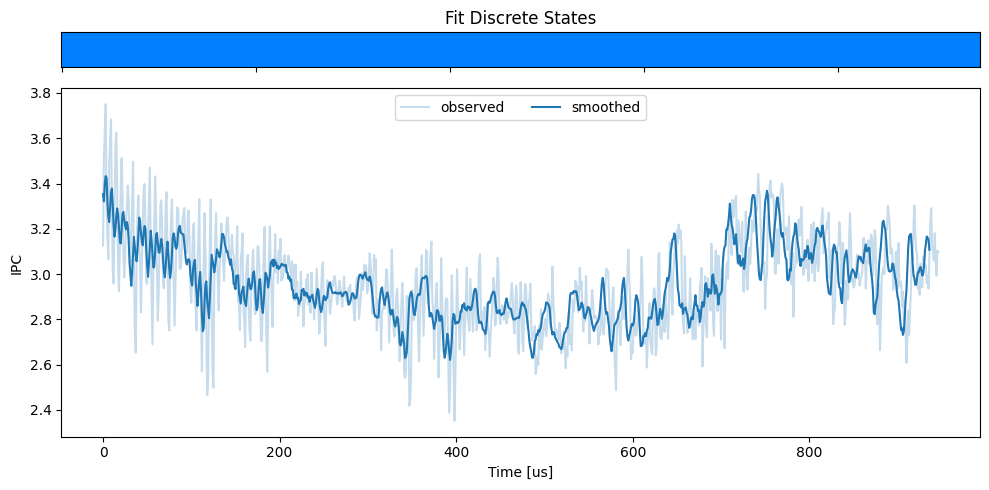

seed: 14


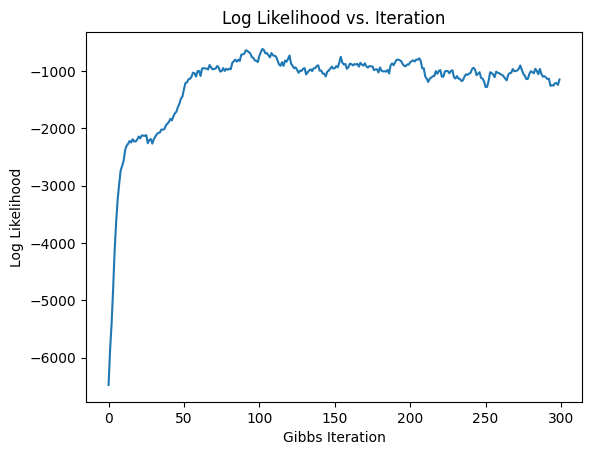

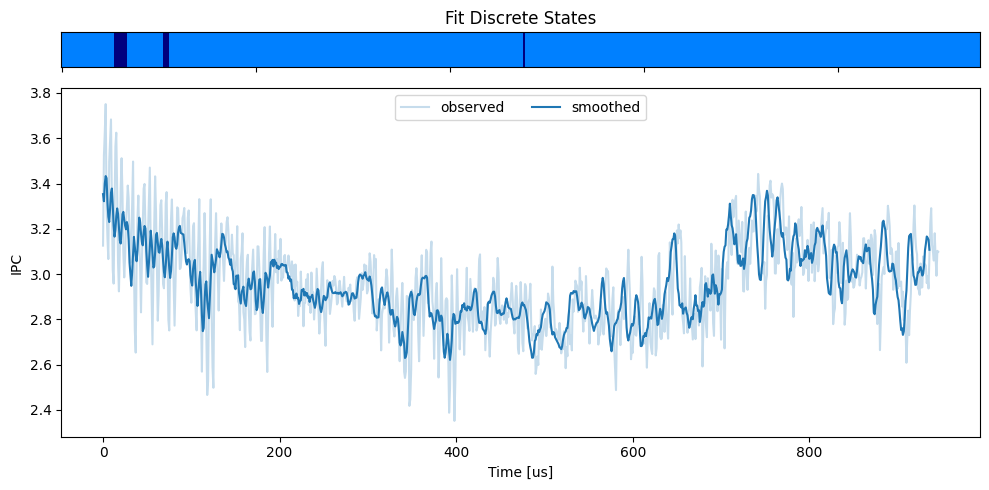

seed: 15


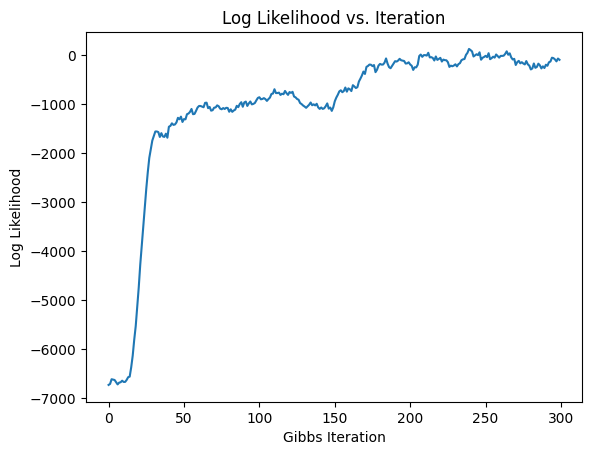

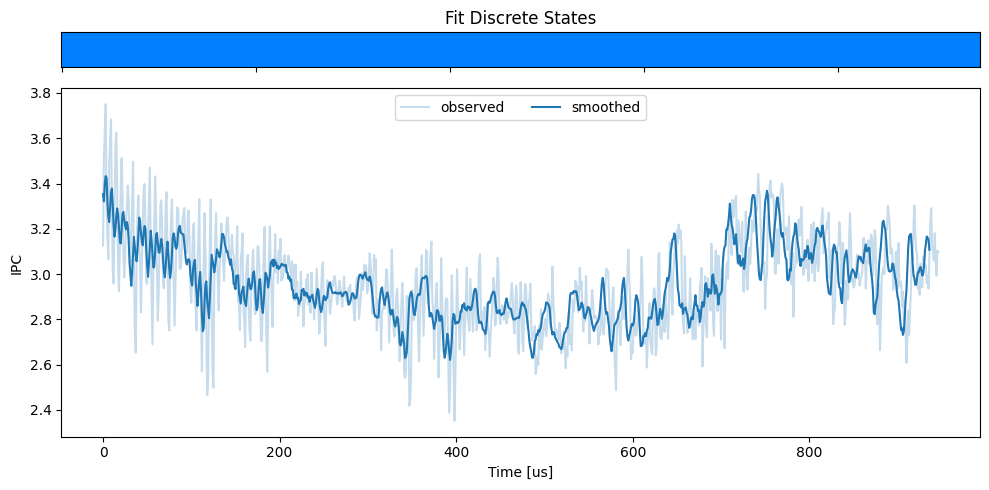

seed: 16


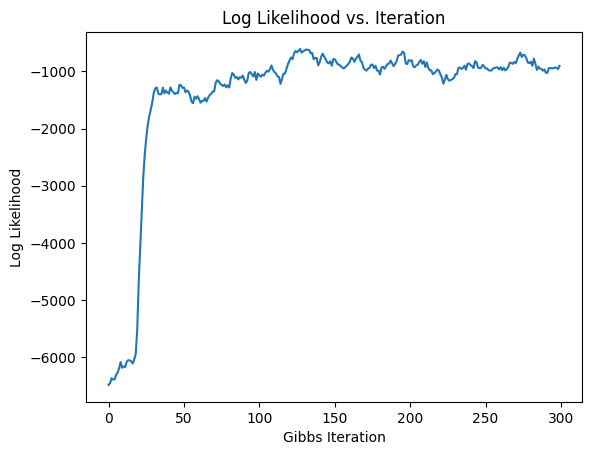

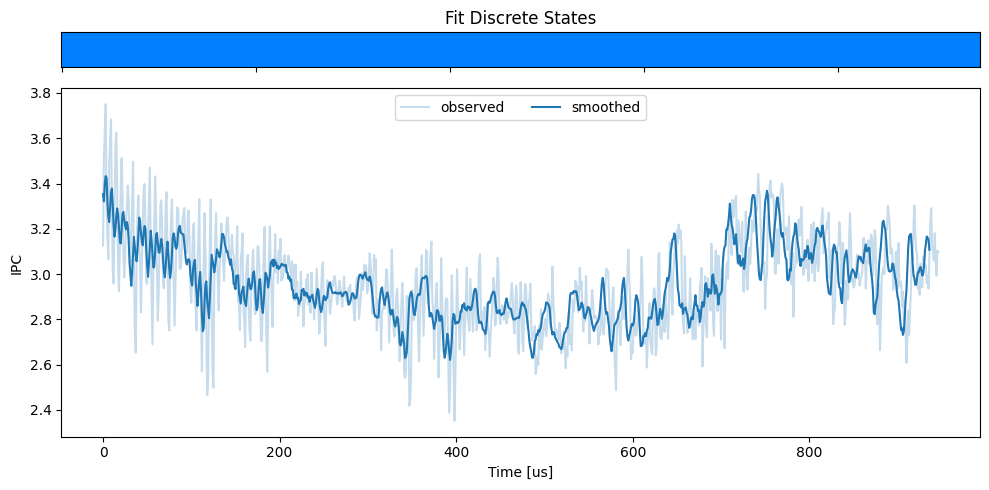

seed: 17


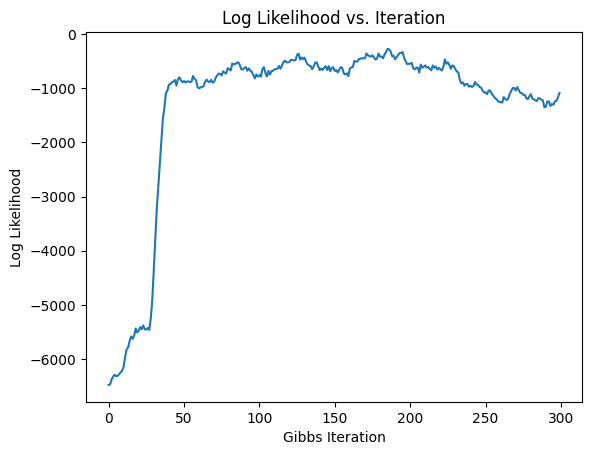

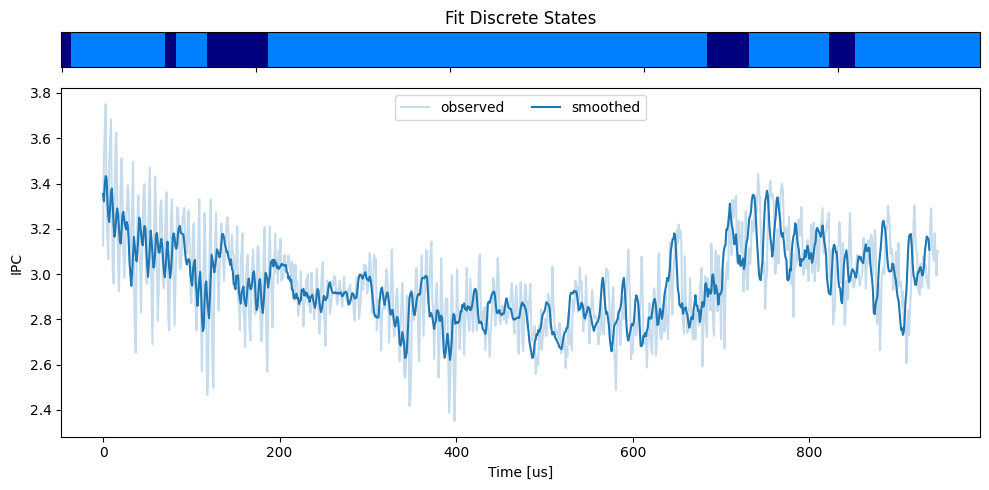

seed: 18


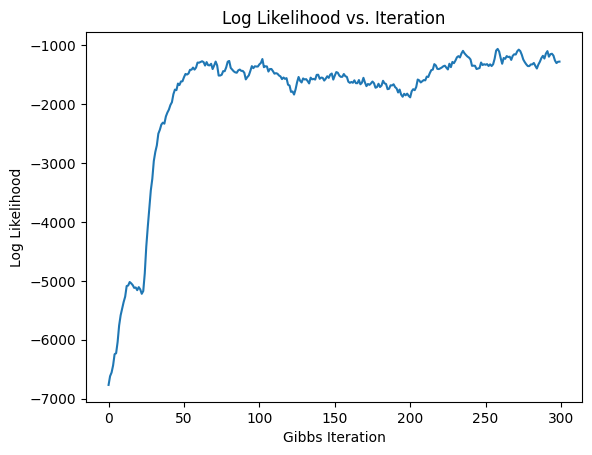

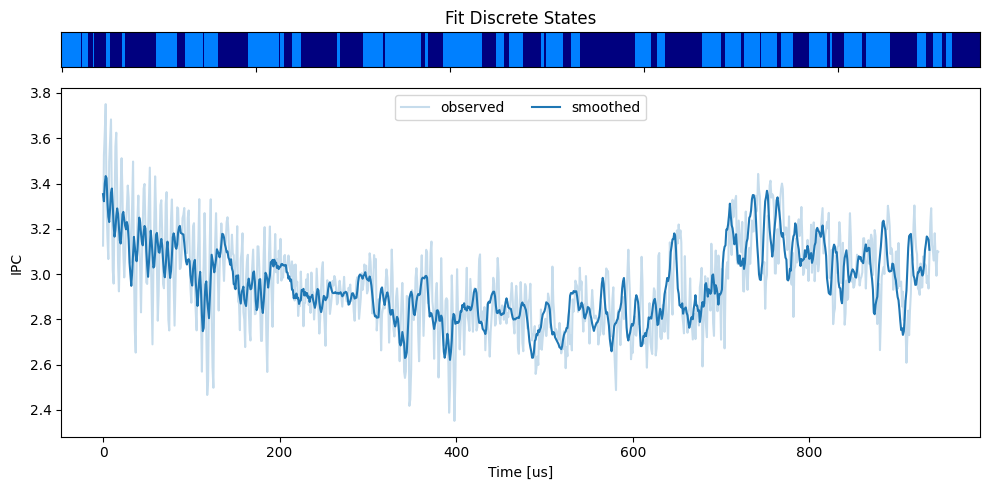

seed: 19


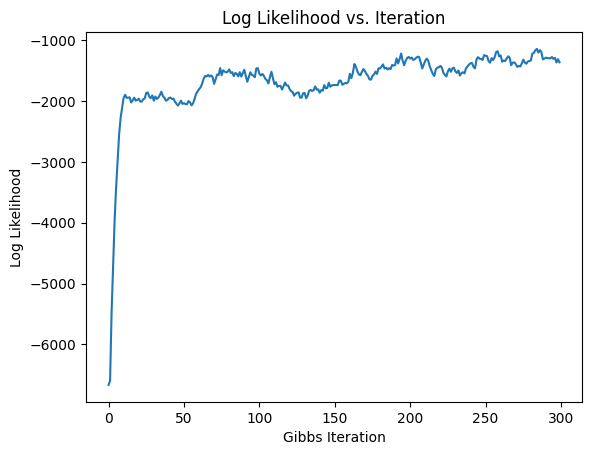

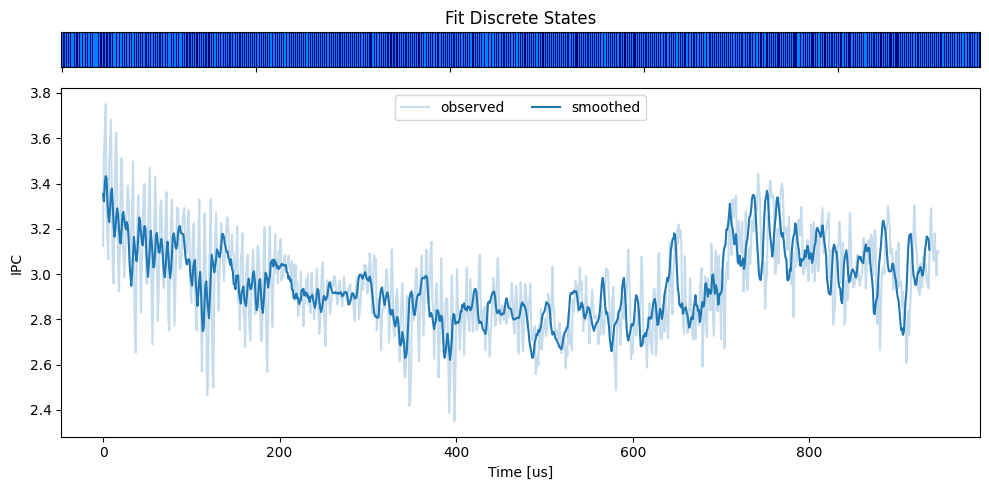

seed: 20


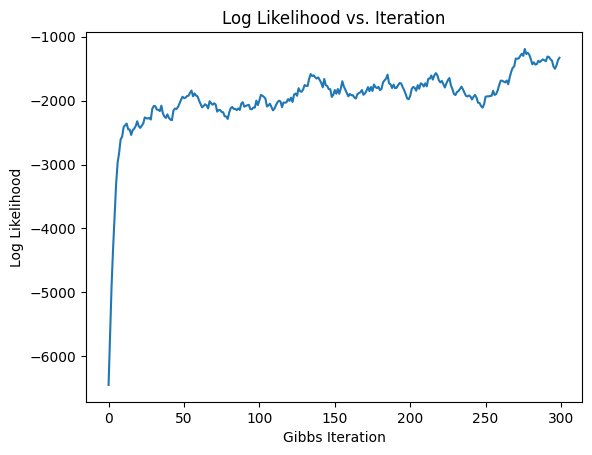

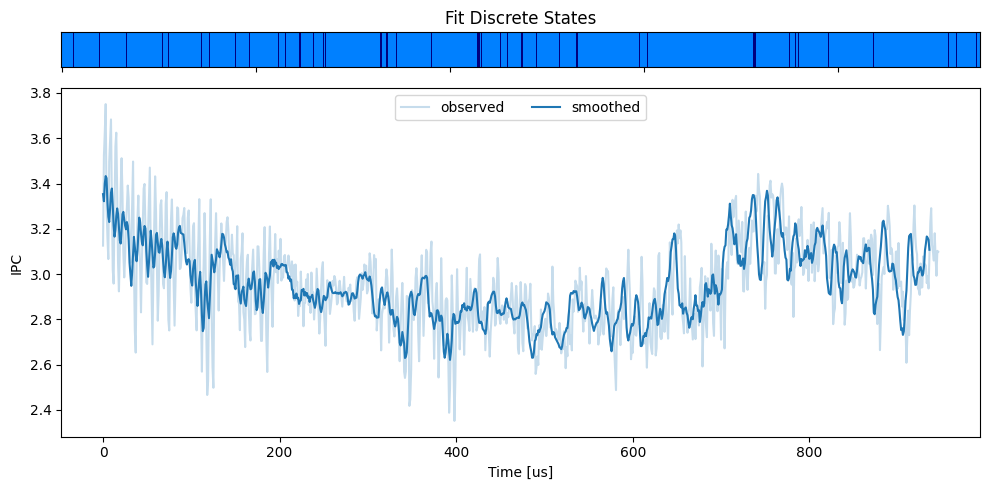

seed: 21


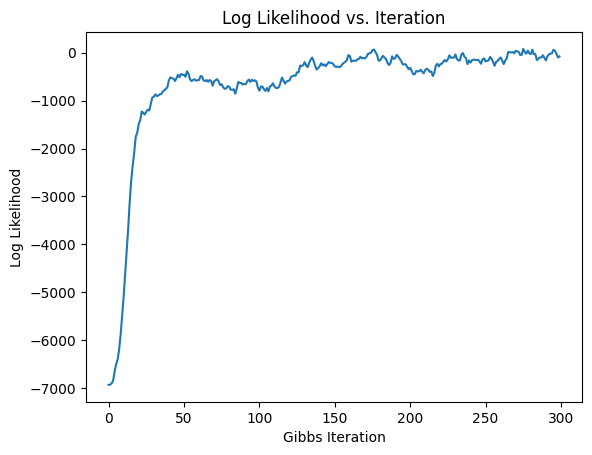

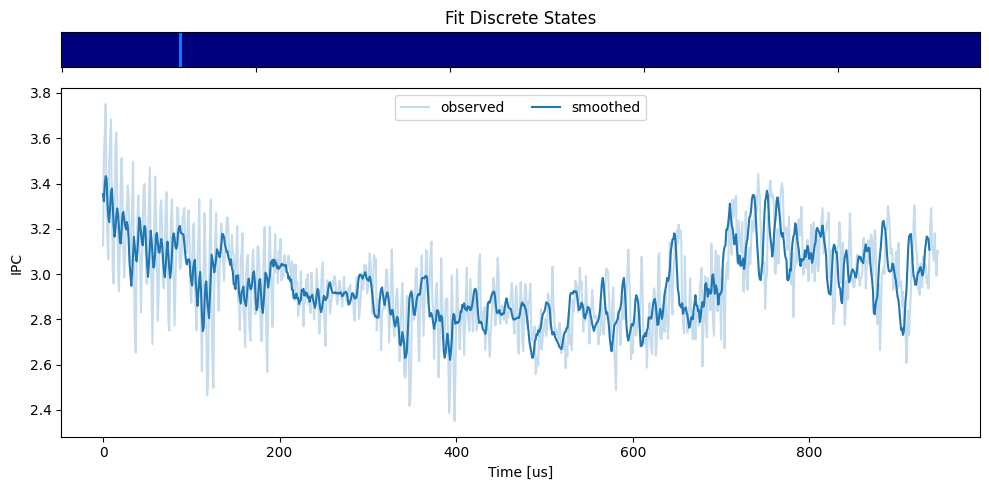

seed: 22


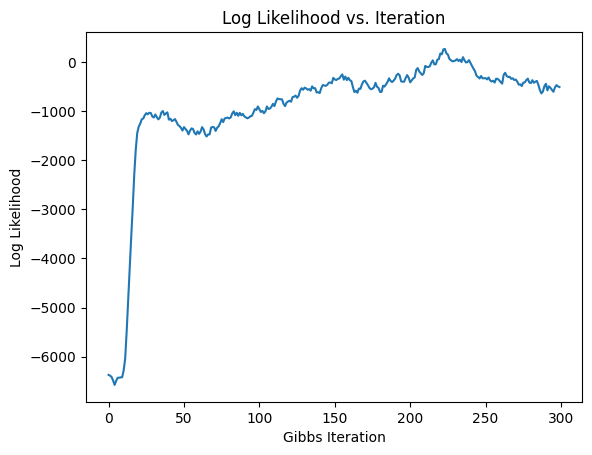

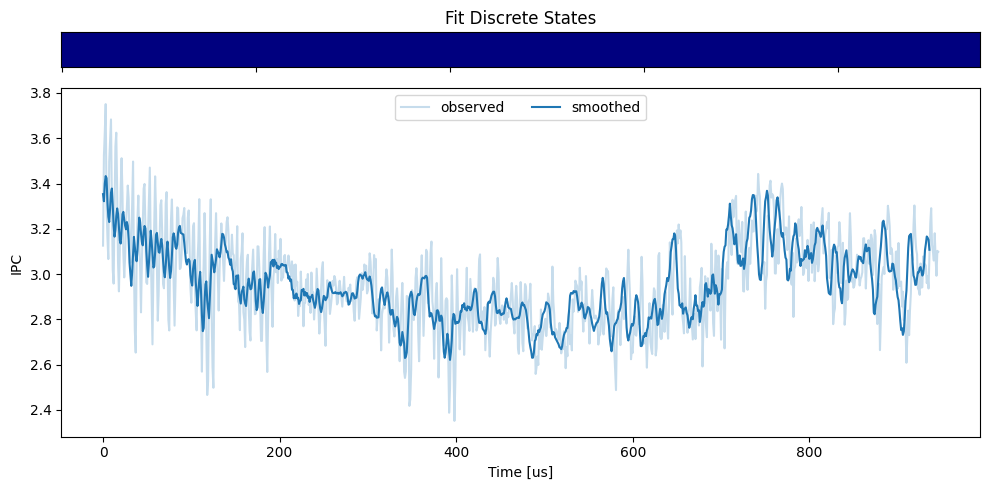

seed: 23


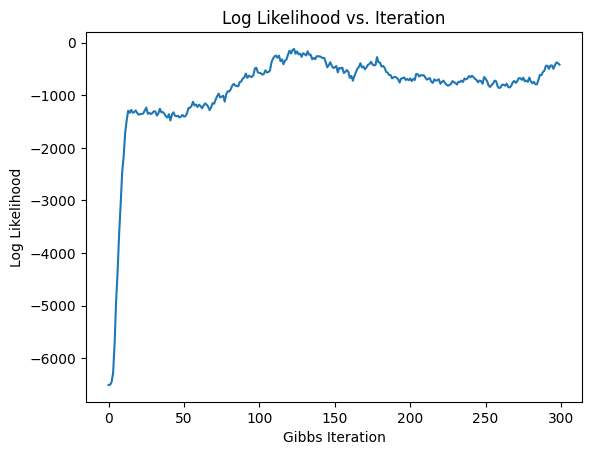

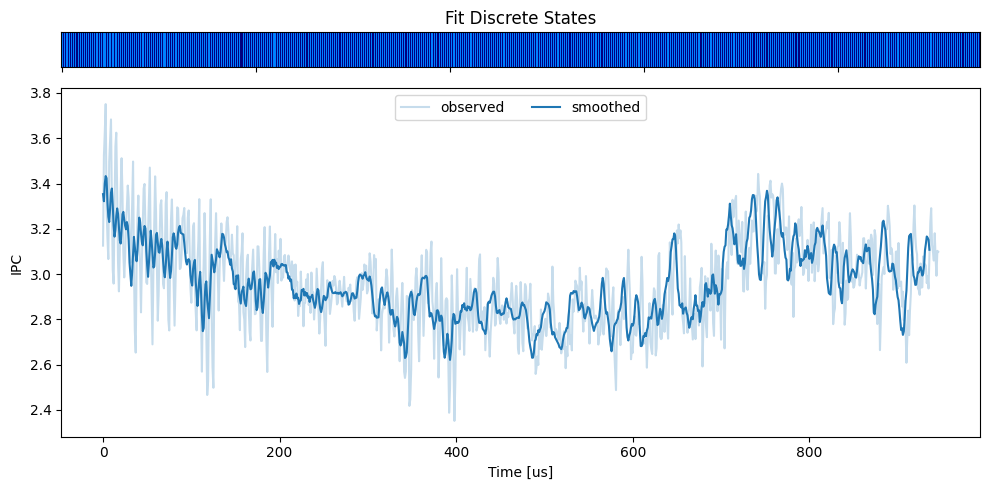

seed: 24


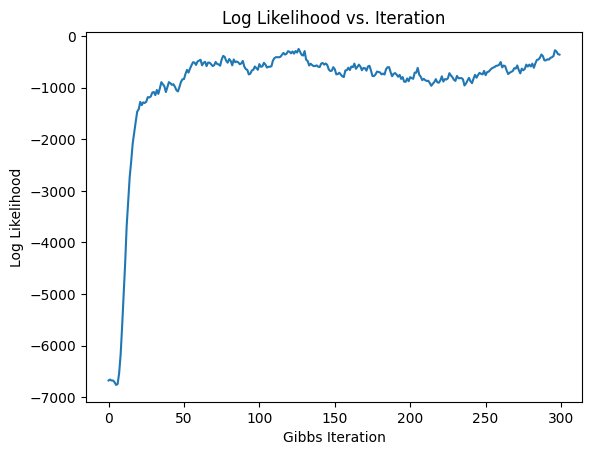

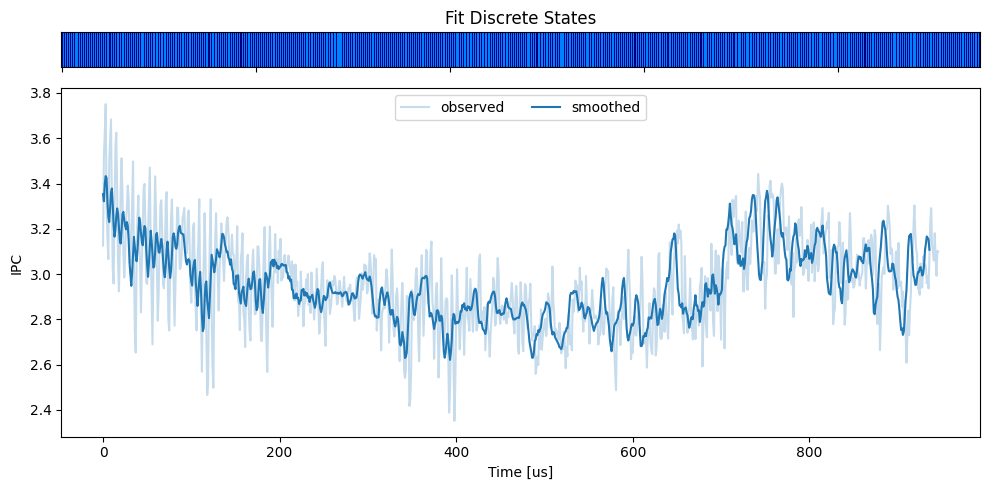

In [28]:
data_config = SegmentationConfig(
    data_source=Path("/forecaster/data/aggregated.pkl"), 
)
segmentation_dataset = SegmentationDataset(data_config) 

seeds = list(range(25))

for seed in seeds: 
    print(f"seed: {seed}")
    npr.seed(seed)
    config = SLDSConfig(
        num_states=2
    )

    As = [random_rotation(config.latent_dimension) for _ in range(config.num_states)]

    model = DefaultSLDS(
        config.num_states, 
        config.observation_dimension, 
        config.latent_dimension, 
        D_input=config.input_dimension, 
        As=As, 
        alpha=1., 
        )
        
    data = segmentation_dataset.data[0]
    smooth: callable = lambda x, order=5: np.convolve(x, np.ones(order) / order, mode="same")[order:-order]

    data = smooth(data[0, :], order=3)

    num_timesteps: int = data.shape[-1]
    fit_proportion: float = 0.75 
    x: np.ndarray = data[:int(num_timesteps * fit_proportion)]

    model.add_data(x[:, None])

    num_gibbs_samples: int = 300
    def initialize(model): 
        model.resample_model()
        return model.log_likelihood()

    #gibs_lls: list = [initialize(model) for _ in progprint_xrange(num_gibbs_samples)]
    gibs_lls: list = [initialize(model) for _ in range(num_gibbs_samples)]

#    num_em_iterations: int = 25
#    def update(model): 
#        model.VBEM_step()
#        return model.log_likelihood()

#    model._init_mf_from_gibbs()
#    vbem_lls = [update(model) for _ in progprint_xrange(num_em_iterations)]

    plt.figure() 
    plt.title("Log Likelihood vs. Iteration")
    plt.xlabel("Gibbs Iteration")
    plt.ylabel("Log Likelihood")
    plt.plot(gibs_lls)
    plt.show()

    colors = [
        'b', 
        'r', 
        'y', 
        'g', 
        'purple'
    ]
    cmap = get_cmap("jet")

    fig = plt.figure(figsize=(10, 5))
    gs = GridSpec(2, 1, height_ratios=[.1, 1.0])
    ax = fig.add_subplot(gs[0, 0])
    ax.imshow(model.states_list[0].stateseq[None, :], vmin=0, vmax=max(len(colors), model.num_states) - 1, cmap=cmap, interpolation="nearest", aspect="auto")
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_title("Fit Discrete States")

    ax = fig.add_subplot(gs[1, 0])
    plt.plot(x, color="tab:blue", label="observed", alpha=0.25)
    plt.plot(smooth(x), color="tab:blue", label="smoothed")
    plt.xlabel("Time [us]")
    plt.ylabel("IPC")
    plt.legend(loc="upper center", ncol=2)
    plt.tight_layout()
    plt.show()

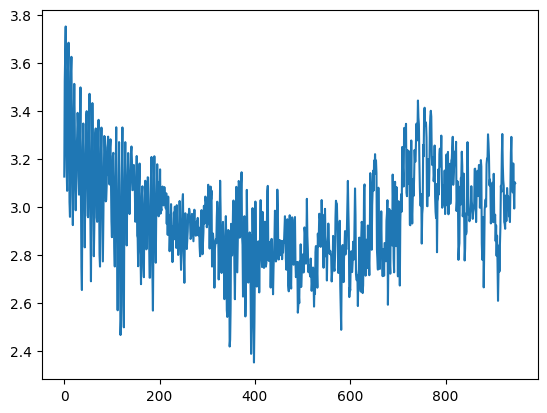

In [8]:
plt.figure()
plt.plot(x)
plt.show()

In [30]:
model.add_data(x[:, None])

In [31]:
num_gibbs_samples: int = 300
def initialize(model): 
    model.resample_model()
    return model.log_likelihood()

gibs_lls: list = [initialize(model) for _ in progprint_xrange(num_gibbs_samples)]

.....

...............

/pybasicbayes/pybasicbayes/distributions/regression.py:139: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([yyT, yxT, xxT, n])


.....  [  25/300,    0.01sec avg, ETA 2.57 ]
.........................  [  50/300,    0.01sec avg, ETA 2.30 ]
.........................  [  75/300,    0.01sec avg, ETA 2.05 ]
.........................  [ 100/300,    0.01sec avg, ETA 1.82 ]
.........................  [ 125/300,    0.01sec avg, ETA 1.59 ]
.........................  [ 150/300,    0.01sec avg, ETA 1.36 ]
.........................  [ 175/300,    0.01sec avg, ETA 1.13 ]
.........................  [ 200/300,    0.01sec avg, ETA 0.90 ]
.........................  [ 225/300,    0.01sec avg, ETA 0.68 ]
.........................  [ 250/300,    0.01sec avg, ETA 0.45 ]
.........................  [ 275/300,    0.01sec avg, ETA 0.23 ]
.........................  [ 300/300,    0.01sec avg, ETA 0.00 ]

   0.01sec avg, 2.69 total



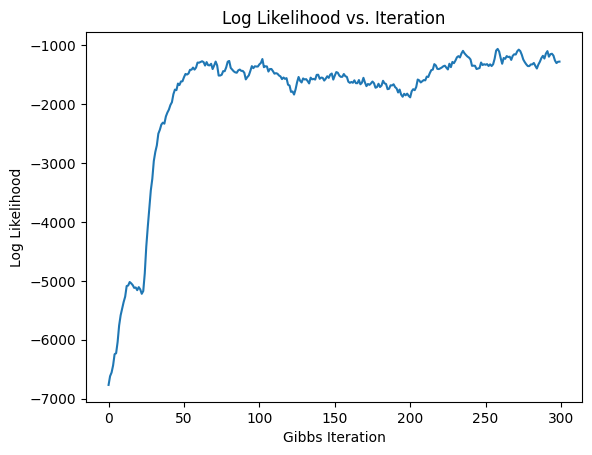

In [32]:
plt.figure() 
plt.title("Log Likelihood vs. Iteration")
plt.xlabel("Gibbs Iteration")
plt.ylabel("Log Likelihood")
plt.plot(gibs_lls)
plt.show()

## Fitting with Variational Bayes EM 

In [12]:
num_em_iterations: int = 1000
def update(model): 
    model.VBEM_step()
    return model.log_likelihood()

#model._init_mf_from_gibbs()
#vbem_lls = [update(model) for _ in progprint_xrange(num_em_iterations)]

In [13]:
#plt.figure()
#plt.plot(vbem_lls)
#plt.show()

In [60]:
colors = [
    'b', 
    'r', 
    'y', 
    'g', 
    'purple'
]
cmap = get_cmap("jet")

plot_range = (250, 370)

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(2, 1, height_ratios=[.1, 1.0])
ax = fig.add_subplot(gs[0, 0])
ax.imshow(model.states_list[0].stateseq[None, plot_range[0]:plot_range[1]], vmin=0, vmax=max(len(colors), model.num_states) - 1, cmap=cmap, interpolation="nearest", aspect="auto")
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_title("Inferred Dynamic Modes")

ax = fig.add_subplot(gs[1, 0])
plt.plot(x[plot_range[0]:plot_range[1]], color="tab:blue", label="observed", alpha=0.25)
plt.plot(smooth(x[plot_range[0]:plot_range[1]]), color="tab:blue", label="smoothed")
plt.xlabel("Time [us]")
plt.ylabel("IPC")
plt.legend(loc="upper center", ncol=2)
plt.tight_layout()

save_path = "/forecaster/figures/slds_fit.pdf"
plt.savefig(save_path)
plt.close()
#plt.show()


/tmp/ipykernel_214717/355837613.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("jet")


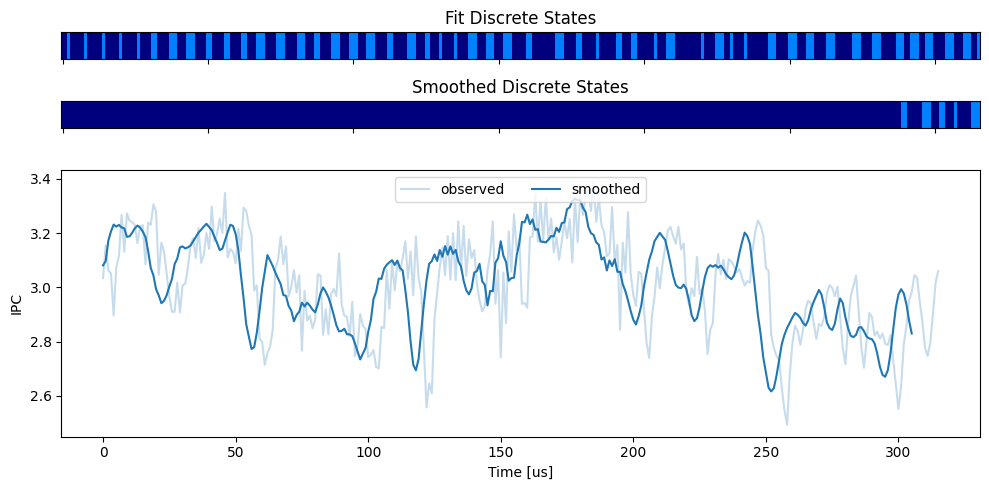

In [54]:
v = model.heldout_viterbi(x_test[:, None])
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(3, 1, height_ratios=[.1, .1, 1.0])
ax = fig.add_subplot(gs[0, 0])
ax.imshow(v[None, :], vmin=0, vmax=max(len(colors), model.num_states) - 1, cmap=cmap, interpolation="nearest", aspect="auto")
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_title("Fit Discrete States")

ax = fig.add_subplot(gs[1, 0])
ax.imshow(custom_smooth(v, kernel_size=10)[None, :], vmin=0, vmax=max(len(colors), model.num_states) - 1, cmap=cmap, interpolation="nearest", aspect="auto")
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_title("Smoothed Discrete States")

ax = fig.add_subplot(gs[2, 0])
plt.plot(x_test, color="tab:blue", label="observed", alpha=0.25)
plt.plot(smooth(x_test), color="tab:blue", label="smoothed")
plt.xlabel("Time [us]")
plt.ylabel("IPC")
plt.legend(loc="upper center", ncol=2)
plt.tight_layout()
plt.show()

In [43]:
def custom_smooth(x: np.ndarray, kernel_size=50) -> np.ndarray: 
    smoothed = np.zeros_like(x)
    for i in range(x.size): 
        window = x[max(0, i-kernel_size):min(x.size, i + kernel_size)]
        values, counts = np.unique(window, return_counts=True)
        most_common = values[np.argmax(counts)]
        smoothed[i] = most_common
    return smoothed 

In [44]:
v = model.heldout_viterbi(x_test[:, None])

In [45]:
smooth_v = custom_smooth(v)

In [46]:
v[:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0], dtype=int32)

In [47]:
smooth_v[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [11]:
def extract_contiguous_regions(x: np.ndarray) -> list: 
    regions = {}

    unique_values = np.unique(x)

    for unique in unique_values: 
        regions[str(unique)] = [] 

        region = [] 
        previous_end: int = 0 
        for i in range(previous_end, x.shape[-1]): 
            if x[i] == unique: 
                region.append(i)
            else: 
                if region: 
                    regions[str(unique)].append(np.array(region))
                    region = [] 
                previous_end = i 

    return regions

In [12]:
regions = extract_contiguous_regions(model.states_list[0].stateseq[None, :][0])

In [13]:
# extract mode datasets
state_sequence = model.states_list[0].stateseq[None, :][0]
regions = extract_contiguous_regions(state_sequence)

In [14]:
regions

{'0': [array([21]),
  array([28, 29, 30, 31, 32]),
  array([34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]),
  array([51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]),
  array([66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
         83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]),
  array([120, 121, 122, 123, 124, 125, 126, 127]),
  array([146]),
  array([162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
         175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
         188, 189, 190, 191, 192]),
  array([225]),
  array([230, 231, 232, 233, 234, 235, 236, 237]),
  array([247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259,
         260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272,
         273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283]),
  array([288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300,
         301, 302, 303, 304, 305, 306, 307, 308, 309, 310]),
  array([332, 33

In [16]:
from copy import deepcopy

master_config = ForecastingConfig(
    data_source="", 
    predictors=None, 
    aggregate_benchmarks=True
)

mode_identifiers = list(regions.keys())
mode_datasets = dict()

for mode in mode_identifiers: 
    _datasets = [] 
    for contiguous_region in regions[mode]: 
        config = deepcopy(master_config)
        if contiguous_region.size < (3 * config.model_memory): 
            pass
        else: 
            _x = x[contiguous_region].copy()
            _t = _x.copy()
            ds = ForecastingDataset(config, lazy=True) 
            ds.from_ndarray(_x[None, :], _t)
            _datasets.append(ds)

    mode_datasets[mode] = _datasets


In [17]:
mode_datasets

{'0': [ForecastingDataset(config=ForecastingConfig(data_source='', model_memory=3, rollout=1, predictors=None, targets='ipc', upsample_factor=1, winsorize=True, front_clip_proportion=0.05, back_clip_proportion=0.05, standardize=False, aggregate_benchmarks=True, train_proportion=0.7, validation_proportion=0.2, test_proportion=0.1), initialized=True, size=0.0 B),
  ForecastingDataset(config=ForecastingConfig(data_source='', model_memory=3, rollout=1, predictors=None, targets='ipc', upsample_factor=1, winsorize=True, front_clip_proportion=0.05, back_clip_proportion=0.05, standardize=False, aggregate_benchmarks=True, train_proportion=0.7, validation_proportion=0.2, test_proportion=0.1), initialized=True, size=0.0 B),
  ForecastingDataset(config=ForecastingConfig(data_source='', model_memory=3, rollout=1, predictors=None, targets='ipc', upsample_factor=1, winsorize=True, front_clip_proportion=0.05, back_clip_proportion=0.05, standardize=False, aggregate_benchmarks=True, train_proportion=0.7

In [19]:
sum_data = mode_datasets['0'][0] + mode_datasets['0'][1]

In [25]:
mode_datasets['0'][1].data["train"][0][0].shape

(2, 1, 3)

In [22]:
sum_data.data["train"][0][0].shape

(4, 1, 3)